<a href="https://colab.research.google.com/github/nmcardoso/galmorpho/blob/master/splus_stamps_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports



In [0]:
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
from astropy.io import fits
from astropy.nddata.utils import Cutout2D
from scipy import ndimage
import numpy as np
import glob
import pandas as pd
import os
import shutil
import tarfile
from zipfile import ZipFile
from multiprocessing import Pool, Lock
from ipywidgets import FloatProgress
from progressbar import progressbar
plt.style.use(astropy_mpl_style)

## Globals

In [0]:
RAW_STAMPS_PATH = '/content/drive/My Drive/splus_data/stamps'
DATAFRAME_PATH = '/content/drive/My Drive/splus_data/tables/group_2_zoo2.csv'

## Preprocess Class

In [0]:
class Preprocess:
  def __init__(self, files_folder, channels, labels, image_dim):
    # NaN, n < 0, n < median -> 0
    normalization_function = lambda e, median: e if not np.isnan(e) and e > median and e > 0.0 else 0.0
    self.norm_vector = np.vectorize(normalization_function)
    self.files_folder = files_folder
    self.labels = labels
    self.image_dim = image_dim
    self.channels = channels
  
  def remove_sky(self, image_array):
    median = np.median(image_array)
    image = self.norm_vector(image_array, median)
    return image

  def rescale(self, image_array):
    image = image_array.copy()
    image /= np.amax(image)
    return image

  def standarize(self, image_array):
    image = image_array.copy()
    image -= np.mean(image)
    image /= np.std(image)
    return image

  def cutout(self, position, size):
    def cutout_func(image_array):
      image = Cutout2D(image_array, position, size)
      image = image.data
      return image
    return cutout_func

  def zoom(self, factor):
    def zoom_func(image_array):
      image = ndimage.zoom(image_array, factor)
      return image
    return zoom_func

  def dataset_mean(self):
    median = {}
    for channel in self.channels:
      median[channel] = []
      for row in progressbar(self.labels.iterrows(), max_value=self.labels.shape[0]):
        image_path = os.path.join(self.files_folder, channel, f'{row[1].ID}_{channel}.fits')
        image_array = fits.getdata(image_path, ext=0)
        median[channel].append(np.median(image_array))
    return median
  
  def exec_pipeline(self, functions, batch_size=None, remove=False):
    for row in progressbar(self.labels.iterrows(), max_value=self.labels.shape[0]):
      image_id = row[1].ID
      image = np.empty((*self.image_dim, len(self.channels)))

      for i, channel in enumerate(self.channels):
        image_path = os.path.join(self.files_folder, channel, f'{image_id}_{channel}.fits')
        image_array = fits.getdata(image_path, ext=0)
        if remove:
          os.remove(image_path) #remove .fits image
        for f in functions:
          image_array = f(image_array)
        image[..., i] = image_array
      
      npy_path = os.path.join(output_path, f'{image_id}.npy')
      np.save(npy_path, image)

      with tarfile.open(os.path.join(output_path, 'dataset.tar'), 'a') as tar:
        tar.add(npy_path, f'{image_id}.npy')

      os.remove(npy_path) # remove .npy file

In [0]:
np.reshape(['F378', 'F395', 'F410', 'F430', 'F515', 'F660', 'F861', 'G', 'I', 'R', 'U', 'Z'], (4,3))

array([['F378', 'F395', 'F410'],
       ['F430', 'F515', 'F660'],
       ['F861', 'G', 'I'],
       ['R', 'U', 'Z']], dtype='<U4')

## Get data from gdrive

In [0]:
!ls "{RAW_STAMPS_PATH}"

F378_stamps.tar.xz  group_2_zoo2.csv
F395_stamps.tar.xz  G_stamps.tar.xz
F410_stamps.tar.xz  I_stamps.tar.xz
F430_stamps.tar.xz  R_stamps.tar.xz
F515_stamps.tar.xz  SPLUS_SQGTool_DR1_mag-17_p_gal_sw_0.7-1.0_group_2.csv
F660_stamps.tar.xz  U_stamps.tar.xz
F861_stamps.tar.xz  Z_stamps.tar.xz


In [0]:
!tar -C /content -xvf "$RAW_STAMPS_PATH/F378_stamps.tar.xz"
!tar -C /content -xvf "$RAW_STAMPS_PATH/F395_stamps.tar.xz"
!tar -C /content -xvf "$RAW_STAMPS_PATH/F410_stamps.tar.xz"
!tar -C /content -xvf "$RAW_STAMPS_PATH/F430_stamps.tar.xz"
!tar -C /content -xvf "$RAW_STAMPS_PATH/F515_stamps.tar.xz"
!tar -C /content -xvf "$RAW_STAMPS_PATH/F660_stamps.tar.xz"
!tar -C /content -xvf "$RAW_STAMPS_PATH/F861_stamps.tar.xz"
!tar -C /content -xvf "$RAW_STAMPS_PATH/G_stamps.tar.xz"
!tar -C /content -xvf "$RAW_STAMPS_PATH/I_stamps.tar.xz"
!tar -C /content -xvf "$RAW_STAMPS_PATH/R_stamps.tar.xz"
!tar -C /content -xvf "$RAW_STAMPS_PATH/U_stamps.tar.xz"
!tar -C /content -xvf "$RAW_STAMPS_PATH/Z_stamps.tar.xz"

In [0]:
!mkdir /content/data

In [0]:
!mv F378/F378_stamps/ data/F378
!mv F395/F395_stamps/ data/F395
!mv F410/F410_stamps/ data/F410
!mv F430/F430_stamps/ data/F430
!mv F515/F515_stamps/ data/F515
!mv F660/F660_stamps/ data/F660
!mv F861/F861_stamps/ data/F861
!mv G/G_stamps data/G
!mv I_stamps/ data/I
!mv R_stamps data/R
!mv U/U_stamps/ data/U
!mv Z/Z_stamps data/Z

## Start Job

In [0]:
def create_sub_dataframe():
  df = pd.read_csv(DATAFRAME_PATH)
  df = df[['ID', 'simple_class']]
  df = df.rename(columns={'simple_class': 'CLASS'})
  df['CLASS'] = df['CLASS'].apply(lambda x: x[0])
  df_E = df[df.CLASS == 'E']
  df_E = df_E[3600:]
  df_S = df[df.CLASS == 'S']
  df = pd.concat([df_E, df_S])
  df.to_csv('/content/dataset.csv', index=False)
  return df

In [0]:
def create_dataframe():
  df = pd.read_csv(DATAFRAME_PATH)
  df = df[['ID', 'simple_class']]
  df = df.rename(columns={'simple_class': 'CLASS'})
  df['CLASS'] = df['CLASS'].apply(lambda x: x[0])
  df = df[df.CLASS != 'A']
  df.to_csv('/content/dataset.csv', index=False)
  return df

In [0]:
df = create_sub_dataframe()
p = Preprocess('/content/data', ['F378', 'F395', 'F410', 'F430', 'F515', 'F660', 'F861', 'G', 'I', 'R', 'U', 'Z'], df, (128, 128))
p.exec_pipeline([p.cutout((128, 128), 128), p.remove_sky, p.rescale], '/content', remove=False)

 40% (1839 of 4557) |########            | Elapsed Time: 0:13:20 ETA:   0:20:26/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
100% (4557 of 4557) |####################| Elapsed Time: 0:37:00 Time:  0:37:00


## Export to gdrive

In [0]:
!xz -k -1zvc -T 0 dataset.tar > "/content/drive/My Drive/datasets/stamps_scaled_12ch_subset_t.tar.xz"

In [0]:
!tar -Oxf dataset.tar.gz | xz -0z > "/content/drive/My Drive/datasets/stamps_scaled_12ch_subset_t.tar.xz"

In [0]:
!cp "/content/dataset.csv" "/content/drive/My Drive/datasets/stamps_scaled_12ch_subset_128px.csv"
!cp "/content/dataset.tar" "/content/drive/My Drive/datasets/stamps_scaled_12ch_subset_128px.tar"

## Tests

In [0]:
!tar -C /content -tvf "$RAW_STAMPS_PATH/I_stamps.tar.xz" | head -20

drwxrwxrwx sagauga/sagauga   0 2020-03-25 16:26 I_stamps/
-rwxrwxrwx sagauga/sagauga 531240 2020-03-25 03:25 I_stamps/filelist
-rwxrwxrwx sagauga/sagauga 273600 2020-03-23 20:13 I_stamps/SPLUS.STRIPE82-0001.02039.griz_I.fits
-rwxrwxrwx sagauga/sagauga 273600 2020-03-23 20:13 I_stamps/SPLUS.STRIPE82-0001.03217.griz_I.fits
-rwxrwxrwx sagauga/sagauga 273600 2020-03-23 20:13 I_stamps/SPLUS.STRIPE82-0001.03462.griz_I.fits
-rwxrwxrwx sagauga/sagauga 273600 2020-03-23 20:13 I_stamps/SPLUS.STRIPE82-0001.03521.griz_I.fits
-rwxrwxrwx sagauga/sagauga 273600 2020-03-23 20:13 I_stamps/SPLUS.STRIPE82-0001.03529.griz_I.fits
-rwxrwxrwx sagauga/sagauga 273600 2020-03-23 20:13 I_stamps/SPLUS.STRIPE82-0001.03897.griz_I.fits
-rwxrwxrwx sagauga/sagauga 273600 2020-03-23 20:13 I_stamps/SPLUS.STRIPE82-0001.04092.griz_I.fits
-rwxrwxrwx sagauga/sagauga 273600 2020-03-23 20:13 I_stamps/SPLUS.STRIPE82-0001.04209.griz_I.fits
-rwxrwxrwx sagauga/sagauga 273600 2020-03-23 20:13 I_stamps/SPLUS.STRIPE82-0001.04261.gri

In [0]:
!tar -C /content -xvf "$RAW_STAMPS_PATH/F378_stamps.tar.xz" F378/F378_stamps/SPLUS.STRIPE82-0070.18623.griz_F378.fits

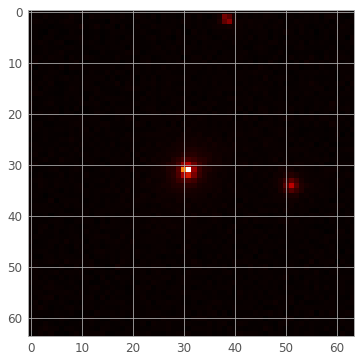

[[0.         0.0068371  0.00805232 ... 0.01380971 0.         0.        ]
 [0.         0.00309328 0.         ... 0.         0.         0.00381486]
 [0.00393158 0.01182008 0.00555721 ... 0.         0.00691319 0.        ]
 ...
 [0.00340735 0.         0.         ... 0.00487374 0.0039124  0.        ]
 [0.         0.         0.00631595 ... 0.         0.00759469 0.        ]
 [0.         0.         0.01078957 ... 0.01447526 0.         0.        ]]


In [0]:
def p(image_array):
  l = lambda e, median: e if not np.isnan(e) and e > median and e > 0.0 else 0.0
  l = np.vectorize(l)
  median = np.median(image_array)
  image = l(np.array(image_array), median)
  image /= np.amax(image)
  return image

im = fits.getdata('/content/I_stamps/SPLUS.STRIPE82-0001.05080.griz_I.fits', ext=0)
# plt.imshow(im)
# plt.show()
# im = p(im)

c = Cutout2D(im, (128, 128), 128)
c1 = Cutout2D(im, (128, 128), 64)
# plt.imshow(c.data)
# plt.show()

m = ndimage.zoom(c.data, 0.5)
plt.imshow(m)
plt.show()

print(p(m))


# Median

In [0]:
df = create_dataframe()
p = Preprocess('/content/data', ['R', 'G', 'Z'], df, (256, 256))
m = p.dataset_mean()

R_mean_min: -0.08060667 R_mean_max: 28.34475


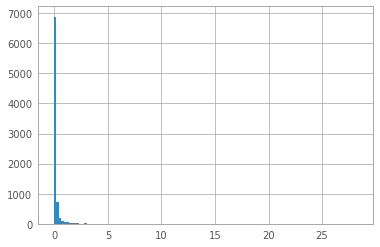

G_mean_min: -0.04681581 G_mean_max: 15.430484


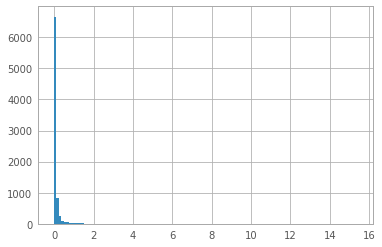

Z_mean_min: -0.40006396 Z_mean_max: 21.851059


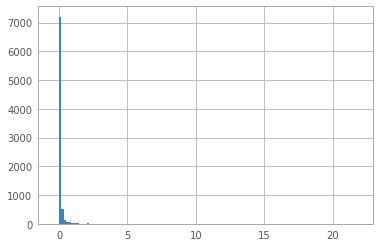

In [0]:
print('R_median_min:', np.amin(m['R']), 'R_median_max:', np.amax(m['R']))
plt.figure()
plt.hist(m['R'], bins=120)
plt.show()
print('G_median_min:', np.amin(m['G']), 'G_median_max:', np.amax(m['G']))
plt.figure()
plt.hist(m['G'], bins=120)
plt.show()
print('Z_median_min:', np.amin(m['Z']), 'Z_median_max:', np.amax(m['Z']))
plt.figure()
plt.hist(m['Z'], bins=120)
plt.show()